## Environment

In [1]:
import numpy as np
from scipy.special import kl_div

In [2]:
class Environment():

  def __init__(self, n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost):
    self.n_arms = n_arms                                            # number of prices
    self.probabilities = probabilities                              # conversion rates for every price/arm
    self.bids = bids                                                # bids
    self.average_number_of_clicks = average_number_of_clicks        # curve of average number of clicks (y = f(bids))
    self.average_cum_daily_cost = average_cum_daily_cost            # curve of cumulative daily cost (y = g(bids))
    self.noise_clicks = noise_clicks                                # gaussian noise for the average number of clicks sampling
    self.noise_cost = noise_cost                                    # gaussian noise for the cumulative daily cost sampling

  # daily rewards
  def bidding_round(self, pulled_bid):
    clicks = int(np.random.normal(self.average_number_of_clicks(self.bids[pulled_bid]),self.noise_clicks))        # number of people that click on the ad
    reward_click = clicks if clicks >= 0 else 0
    costs = np.random.normal(self.average_cum_daily_cost(self.bids[pulled_bid]),self.noise_cost)                  # cumulative daily cost
    reward_cost = costs if costs > 0 else 0

    return reward_click, reward_cost

  def pricing_round(self, pulled_price):
    reward_price = np.random.binomial(1,self.probabilities[pulled_price])                         # number of people that buy once they clicked
    return reward_price

In [3]:
class CUSUM(): 
    def __init__(self, M, eps, h):
        self.M = M #used to compute reference point
        self.eps = eps
        self.h = h #treshold
        self.t = 0
        self.reference = 0
        self.g_plus = 0
        self.g_minus = 0
    
    def update (self, sample):   #compute mean before we reach M (not enough samples), after we compute variables
        self.t += 1
        if self.t <= self.M:
            self.reference += sample/self.M 
            return 0
        else:
            s_plus = (sample - self .reference) - self.eps
            s_minus = - (sample - self.reference) - self.eps
            self.g_plus = max(0, self.g_plus + s_plus)
            self.g_minus = max(0, self .g_minus + s_minus)
            return self.g_plus > self.h or self.g_minus > self.h
    def reset (self):    #resets when a change is detected
        self.t = 0
        self.g_plus = 0
        self.g_minus = 0

## Non-stationnary environment

In [4]:
class NonStationnary(Environment):
  def __init__(self, n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost,
              time_abrupt_change_1, time_abrupt_change_2):
    super().__init__(n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost)
    self.time_abrupt_change_1 = time_abrupt_change_1
    self.time_abrupt_change_2 = time_abrupt_change_2
    #n_phases = len(self.probabilities)
    #self.phases_size = bids/n_phases
  def pricing_round(self, pulled_price):
    print("Error: Non-stationnary environment needs the time to know the conversion rates!")
    return float("NaN")
    
  def pricing_round(self, pulled_price, time):
    if time < self.time_abrupt_change_1:
      reward_price = np.random.binomial(1,self.probabilities[0,pulled_price])
    elif time < self.time_abrupt_change_2:
      reward_price = np.random.binomial(1,self.probabilities[1,pulled_price])
    else:
      reward_price = np.random.binomial(1,self.probabilities[2,pulled_price])
    return reward_price
    

## Pricing

In [5]:
class Learner:
  def __init__(self,n_arms):
    self.n_arms = n_arms
    self.t = 0                                              # current round value
    self.rewards_per_arm = x = [[] for i in range(n_arms)]  # value of collected rewards for each round and for each arm
    self.collected_rewards = np.array([])                   # values of collected rewards for each round

  # function that updates the observation's list once the reward is returned by the environment
  def update_observations(self, pulled_arm, reward):
    self.rewards_per_arm[pulled_arm].append(reward)
    self.collected_rewards = np.append(self.collected_rewards,reward)

In [6]:
class TS_Pricing_Learner(Learner): # Thompson-Sampling (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices):
    super().__init__(n_arms)                    # number of prices
    self.beta_parameters = np.ones((n_arms,2))  # parameters of beta distributions
    self.prices = prices                        # prices (array)

    #self.empirical_means = np.zeros(n_arms)

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    sampled = np.random.beta(self.beta_parameters[:,0],self.beta_parameters[:,1])*self.prices
    idx = np.argmax(sampled)
    #return idx, sampled[idx]
    return idx

  # update parameters each time a reward in {0,1} is observed
  def update(self,pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm,reward*self.prices[pulled_arm])
    self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + reward
    self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + 1 - reward

    #self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(len(self.rewards_per_arm[pulled_arm]) - 1) + reward*self.prices[pulled_arm] ) / len(self.rewards_per_arm[pulled_arm])

In [7]:
class UCB_Pricing_Learner(Learner): # UCB1 (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms, prices):
    super().__init__(n_arms)                              # number of arms/prices
    self.empirical_means = np.zeros(n_arms)               # mean reward for each arm (conversion rate)
    self.confidence = np.zeros(n_arms)                    # confidence bound for each arm
    self.prices = prices                                  # prices (array)

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    upper_bound = self.empirical_means + self.confidence
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    #return pulled_arm, upper_bound[pulled_arm]
    #return pulled_arm, self.empirical_means[pulled_arm]
    return pulled_arm

  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward*self.prices[pulled_arm])
    self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(len(self.rewards_per_arm[pulled_arm]) - 1) + reward*self.prices[pulled_arm] ) / len(self.rewards_per_arm[pulled_arm])
    for a in range(self.n_arms):
      self.confidence[a] = self.prices[a]*np.sqrt(2*np.log(self.t)/len(self.rewards_per_arm[a])) if len(self.rewards_per_arm[a]) > 0 else 1e3

In [8]:
import numpy as np 
from scipy.optimize import linear_sum_assignment 

class CUSUM_UCB_Matching(UCB_Pricing_Learner) :
    def __init__(self, n_arms, prices, M=100, eps=0.05, h=20, alpha=0.01):
        super().__init__(n_arms, prices)
        self.change_detection = [CUSUM(M, eps, h) for _ in range (n_arms)]
        self.valid_rewards_per_arm = [[] for _ in range (n_arms)]  #keeps all rewards that we have got after last CD
        self.detections = [[] for _ in range (n_arms)] #time of detection per arm
        self.alpha = alpha  #prob of taking a non optimal arm
      
    def pull_arm(self):
        if(self.t < self.n_arms):
            return self.t
        if np.random.binomial (1, 1-self.alpha):
            upper_bound = self.empirical_means + self.confidence
            upper_bound [np.isinf (upper_bound)] = 1e6 #avoiding inf case
            pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
            return pulled_arm
        else:
            arm_random = np.random.randint(0, self.n_arms)
            return arm_random
        
    def update(self, pulled_arm, reward):
        self.t += 1
        if self.change_detection[pulled_arm].update(reward):
            self.detections[pulled_arm].append (self.t)
            self.valid_rewards_per_arm[pulled_arm] =[]
            self.change_detection[pulled_arm].reset()
        self.update_observations(pulled_arm, reward)
        self.empirical_means[pulled_arm] = np.mean(self.valid_rewards_per_arm[pulled_arm])
        total_valid_samples = sum([len(x) for x in self.valid_rewards_per_arm]) 
        for a in range (self.n_arms):
            n_samples = len(self.valid_rewards_per_arm[a])
            self.confidence[a] = (2*np.log(total_valid_samples)/n_samples)**0.5 if n_samples > 0 else np.inf
                                                            
    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.valid_rewards_per_arm [pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards, reward)
        
    def total_numofchanges(self):
        numchanges = 0
        for i in range (self.n_arms):
            numchanges += len(self.detections[i])
        return numchanges

## Simulation

In [9]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [10]:
# generic
T = 365                                # horizon of experiment
n_experiments = 100                    # since the reward functions are stochastic, to better visualize the results and remove the noise we do multiple experiments

In [11]:
# pricing
n_prices = 5
prices = [5,6,7,8,9]
p = np.array([[0.15,0.1,0.1,0.35,0.1],
              [0.5,0.2,0.1,0.1,0.1],
              [0.1,0.1,0.1,0.2,0.5]])             # bernoulli distributions for the reward functions

time_abrupt_change_1 = 100
time_abrupt_change_2 = 200
opt_rate_0 = p[0, np.argmax(p[0,:]*prices)]                 # optimal arm
opt_rate_1 = p[1, np.argmax(p[1,:]*prices)] 
opt_rate_2 = p[2, np.argmax(p[2,:]*prices)] 
print("Pricing (optimal price):")
print("Before change:")
print(" idx: " + str(np.argmax(p[0,:]*prices)) + 
      "  price: " + str(prices[np.argmax(p[0,:]*prices)]) + 
      "  rate: " + str(opt_rate_0) + 
      "  price*rate: " + str(opt_rate_0*prices[np.argmax(p[0,:]*prices)]))
print("After 1 change:")
print(" idx: " + str(np.argmax(p[1,:]*prices)) + 
      "  price: " + str(prices[np.argmax(p[1,:]*prices)]) + 
      "  rate: " + str(opt_rate_1) + 
      "  price*rate: " + str(opt_rate_1*prices[np.argmax(p[1,:]*prices)]))
print("After 2 changes:")
print(" idx: " + str(np.argmax(p[2,:]*prices)) + 
      "  price: " + str(prices[np.argmax(p[2,:]*prices)]) + 
      "  rate: " + str(opt_rate_2) + 
      "  price*rate: " + str(opt_rate_2*prices[np.argmax(p[2,:]*prices)]))

Pricing (optimal price):
Before change:
 idx: 3  price: 8  rate: 0.35  price*rate: 2.8
After 1 change:
 idx: 0  price: 5  rate: 0.5  price*rate: 2.5
After 2 changes:
 idx: 4  price: 9  rate: 0.5  price*rate: 4.5


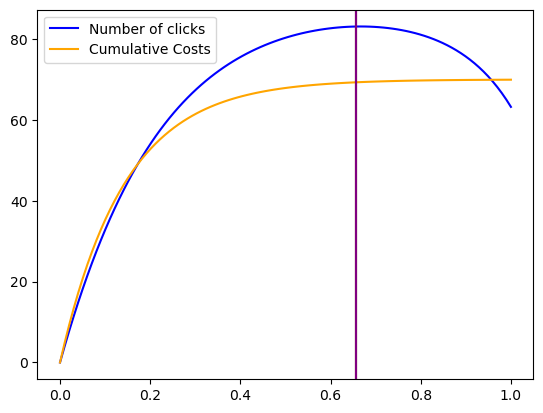

In [12]:
# advertising
n_bids = 100
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_bids)
sigma_clicks = 3
sigma_costs = 3
def clicks(x):
  return 100 * (1.0 - np.exp(-4*x+3*x**3))
def costs(x):
  return 70 * (1.0 - np.exp(-7*x))
opt_bid_0 = bids[np.argmax(opt_rate_0*prices[np.argmax(p[0,:]*prices)]*clicks(bids)-costs(bids))]
opt_bid_1 = bids[np.argmax(opt_rate_1*prices[np.argmax(p[1,:]*prices)]*clicks(bids)-costs(bids))]
opt_bid_2 = bids[np.argmax(opt_rate_2*prices[np.argmax(p[2,:]*prices)]*clicks(bids)-costs(bids))]
fig, ax = plt.subplots()
ax.plot(bids,clicks(bids),'blue',bids,costs(bids),'orange')
ax.legend(["Number of clicks", "Cumulative Costs"])
ax.axvline(opt_bid_0,c='red')
ax.axvline(opt_bid_1,c='green')
ax.axvline(opt_bid_2,c='purple')
# print("Advertising (optimal bid):")
# print("idx: " + str(np.argmax(opt_rate*prices[np.argmax(p*prices)]*clicks(bids)-costs(bids))) + "  bid: " + str(opt_bid) + "  clicks-costs: " + str(clicks(opt_bid)-costs(opt_bid)))

## Known advertising

In [13]:
#variables for CUSUM algorithm
M = 1
#1260
#eps = 0.1
eps = 10.1
#h = np.log(T*10000)*2
h = np.log(T*10)*2
alpha = 0.001
# experiments
n_experiments = 2
ts_rewards_per_experiment = []
ucb_rewards_per_experiment = []
cusum_rewards_per_experiment =[]

cusum_numofchanges_per_experiment =[]

#look at number of changes per arm; sum them up; print average 

for e in tqdm(range(0,n_experiments)):  # cycle on experiments
  env = NonStationnary(n_arms = n_prices,
                       probabilities = p,
                       bids = bids,
                       average_number_of_clicks = clicks,
                       average_cum_daily_cost = costs,
                       noise_clicks = sigma_clicks,
                       noise_cost = sigma_costs,
                       time_abrupt_change_1 = time_abrupt_change_1,
                       time_abrupt_change_2 = time_abrupt_change_2)
  ts_learner = TS_Pricing_Learner(n_arms = n_prices,
                                       prices = prices)
  ucb_learner = UCB_Pricing_Learner(n_arms = n_prices,
                                    prices = prices)
  cusum_learner = CUSUM_UCB_Matching (n_arms = n_prices, prices = prices, M = M, eps=eps, h=h, alpha=alpha)


  ts_collected_costs = np.array([])
  ucb_collected_costs = np.array([])
  cusum_collected_costs = np.array([])
  ts_daily_pricing_reward = np.array([])
  ucb_daily_pricing_reward = np.array([])
  cusum_daily_pricing_reward = np.array([])

  for t in range(0,T):  # cycle on time horizon

    # TS
    pulled_bid = np.argmax(clicks(bids)-costs(bids))
    reward_click, reward_cost = env.bidding_round(pulled_bid)
    ts_collected_costs = np.append(ts_collected_costs, reward_cost)
    for k in range(reward_click):
      pulled_price = ts_learner.pull_arm()
      reward_price = env.pricing_round(pulled_price, t)
      ts_learner.update(pulled_price, reward_price)
    ts_daily_pricing_reward = np.append(ts_daily_pricing_reward,(reward_click>0)*np.sum(ts_learner.collected_rewards[-reward_click:]))


    # UCB
    pulled_bid = np.argmax(clicks(bids)-costs(bids))
    reward_click, reward_cost = env.bidding_round(pulled_bid)
    ucb_collected_costs = np.append(ucb_collected_costs, reward_cost)
    for k in range(reward_click):
      pulled_price = ucb_learner.pull_arm()
      reward_price = env.pricing_round(pulled_price, t)
      ucb_learner.update(pulled_price, reward_price)
    ucb_daily_pricing_reward = np.append(ucb_daily_pricing_reward,(reward_click>0)*np.sum(ucb_learner.collected_rewards[-reward_click:]))

    # CUSUM
    pulled_bid = np.argmax(clicks(bids)-costs(bids))
    reward_click, reward_cost = env.bidding_round(pulled_bid)
    cusum_collected_costs = np.append(cusum_collected_costs, reward_cost)
    for k in range(reward_click):
      pulled_price = cusum_learner.pull_arm()
      reward_price = env.pricing_round(pulled_price, t)
      cusum_learner.update(pulled_price, reward_price)
    cusum_daily_pricing_reward = np.append(cusum_daily_pricing_reward,(reward_click>0)*np.sum(cusum_learner.collected_rewards[-reward_click:]))
    
    
    
  ts_rewards_per_experiment.append(ts_daily_pricing_reward - ts_collected_costs)
  ucb_rewards_per_experiment.append(ucb_daily_pricing_reward - ucb_collected_costs)
  cusum_rewards_per_experiment.append(cusum_daily_pricing_reward - cusum_collected_costs)

  cusum_numofchanges_per_experiment.append(cusum_learner.total_numofchanges())

100%|█████████████████████████████████████████████| 2/2 [00:23<00:00, 11.91s/it]


In [14]:
cusum_numofchanges_per_experiment

[0, 0]

In [15]:
opt_0 = [opt_rate_0*prices[np.argmax(p[0,:]*prices)]*clicks(opt_bid_0) - costs(opt_bid_0) 
         for i in range(time_abrupt_change_1)]
opt_1 = [opt_rate_1*prices[np.argmax(p[1,:]*prices)]*clicks(opt_bid_1) - costs(opt_bid_1) 
         for i in range(time_abrupt_change_2-time_abrupt_change_1)]
opt_2 = [opt_rate_2*prices[np.argmax(p[2,:]*prices)]*clicks(opt_bid_2) - costs(opt_bid_2) 
         for i in range(T-time_abrupt_change_2)]
opt = np.array(opt_0 + opt_1 + opt_2)

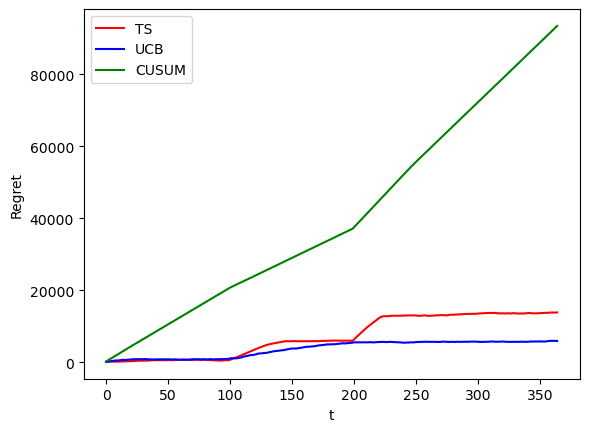

In [16]:
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis = 0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis = 0)), 'b')
plt.plot(np.cumsum(np.mean(opt - cusum_rewards_per_experiment, axis = 0)), 'g')
plt.legend(["TS", "UCB", "CUSUM"])